In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [6]:
# Retrieve inputs
%store -r X_motion_01_3D
%store -r X_motion_02_3D
%store -r X_motion_03_3D
%store -r X_motion_04_3D
%store -r X_motion_05_3D
%store -r X_motion_06_3D
%store -r X_motion_07_3D
%store -r X_motion_08_3D
%store -r X_motion_09_3D

# Retrieve labels
%store -r Y_motion_01_3D
%store -r Y_motion_02_3D
%store -r Y_motion_03_3D
%store -r Y_motion_04_3D
%store -r Y_motion_05_3D
%store -r Y_motion_06_3D
%store -r Y_motion_07_3D
%store -r Y_motion_08_3D
%store -r Y_motion_09_3D

In [8]:
print(X_motion_01_3D.shape)
print(X_motion_02_3D.shape)
print(X_motion_03_3D.shape)
print(X_motion_04_3D.shape)
print(X_motion_05_3D.shape)
print(X_motion_06_3D.shape)
print(X_motion_07_3D.shape)
print(X_motion_08_3D.shape)
print(X_motion_09_3D.shape)

(691, 18)
(658, 18)
(601, 18)
(618, 18)
(552, 18)
(557, 18)
(597, 18)
(504, 18)
(681, 18)


In [125]:
print(Y_motion_01_3D.shape)
print(Y_motion_02_3D.shape)
print(Y_motion_03_3D.shape)
print(Y_motion_04_3D.shape)
print(Y_motion_05_3D.shape)
print(Y_motion_06_3D.shape)
print(Y_motion_07_3D.shape)
print(Y_motion_08_3D.shape)
print(Y_motion_09_3D.shape)

(691, 12)
(658, 12)
(601, 12)
(618, 12)
(552, 12)
(557, 12)
(597, 12)
(504, 12)
(681, 12)


In [126]:
X_motions_3D = np.concatenate((X_motion_01_3D, X_motion_02_3D, X_motion_03_3D, X_motion_04_3D, X_motion_05_3D, X_motion_06_3D, X_motion_07_3D, X_motion_08_3D))
print(X_motions_3D.shape)

(4778, 18)


In [127]:
Y_motions_3D = np.concatenate((Y_motion_01_3D, Y_motion_02_3D, Y_motion_03_3D, Y_motion_04_3D, Y_motion_05_3D, Y_motion_06_3D, Y_motion_07_3D, Y_motion_08_3D))
print(Y_motions_3D.shape)

(4778, 12)


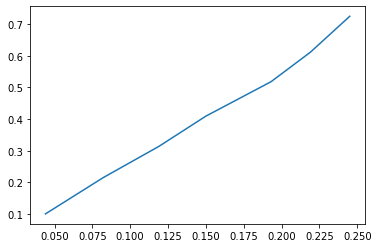

In [128]:
#plt.plot([0.044, 0.082, 0.119, 0.15, 0.193, 0.219, 0.245, 0.270], [0.1, 0.214359, 0.313843, 0.409412, 0.518221, 0.611591, 0.725299, 0.809811])
plt.plot([0.044, 0.082, 0.119, 0.15, 0.193, 0.219, 0.245], [0.1, 0.214359, 0.313843, 0.409412, 0.518221, 0.611591, 0.725299])

# Multivariate Linear Regression (Foot prediction)

The input will use initially only:

- **HighCmd: fwd, side, rot speeds**
- **HighState: fwd, side, rot speeds, footPosition2Body (FR)**

and as output we seek to predict the following:

- **footPosition2Body (FR)**

In [129]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, cross_val_predict

In [130]:
def plot_target_and_predictions(title: str, predictions, target):
    fig, ax1 = plt.subplots(1,1, figsize=(15,10))
    fig.suptitle(title)
    
    # FR plot (height)
    ax1.plot(range(predictions.shape[0]), predictions, 'b-')
    ax1.set_ylabel('Predictions')
    ax1.set_xlabel('Time')
         
    # FR plot (force)
    ax2 = ax1.twinx()
    ax2.plot(range(predictions.shape[0]), target, 'g-')
    ax2.set_ylabel('Target', color='g')

    for tl in ax2.get_yticklabels():
        tl.set_color('g')
    
    fig.tight_layout()
    plt.show()

## Predict FR foot -> (x,y)

In [131]:
X_motions_3D[1, :]

array([ 0.1       ,  0.        ,  0.        ,  0.218044  , -0.00145623,
        0.0386209 ,  0.199479  , -0.143072  , -0.412846  ,  0.253749  ,
        0.153074  , -0.399809  , -0.225485  , -0.109741  , -0.416243  ,
       -0.273453  ,  0.142249  , -0.411675  ])

In [132]:
Y_motions_3D[1, :]

array([ 0.261243, -0.115034, -0.411631,  0.206181,  0.132825, -0.402831,
       -0.273154, -0.124435, -0.415086, -0.220168,  0.150324, -0.409264])

In [208]:
# Stack motion command, velocity state, 
# and foot x coordinate in order to 
# create the input matrix. We dont consider
# the last row.
X = np.hstack((X_motions_3D[:, :3], X_motions_3D[:, 3:6], X_motions_3D[:, 6:8], X_motions_3D[:, 9:11]))

# Label matrix which consists only of
# the next x coordinate of the FR foot.
# We dont consider the first row.
Y = Y_motions_3D[:, :2]

# Make sure we have the same
# number of rows for both labels
# and input
assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

# Create the model
model_fr_full = LinearRegression()

# Fit the model
model_fr_full.fit(X_train, Y_train)

# Predict
predictions = model_fr_full.predict(X_test)

# MSE stats
print("Model score: ", model_fr_full.score(X_train, Y_train))
print("The lowest error is: ", np.min(np.linalg.norm(predictions[:, :-1] - Y_test[:, :-1], axis=1)))
print("The highest error is: ", np.max(np.linalg.norm(predictions[:, :-1] - Y_test[:, :-1], axis=1)))
print("The avg. error is: ", np.mean(np.linalg.norm(predictions[:, :-1] - Y_test[:, :-1], axis=1)))
print("The mean squared avg. error between the prediction and groundtruth is: ", mean_squared_error(Y_test, predictions))
#print("Seq of errors (descendant): \n", sorted(np.linalg.norm(predictions[:, :-1] - Y_test[:, :-1], axis=1).tolist(), reverse=True))

Model score:  0.8147717958630494
The lowest error is:  1.79186567030587e-05
The highest error is:  0.16459872514770751
The avg. error is:  0.009257189326596069
The mean squared avg. error between the prediction and groundtruth is:  0.00017579922504436376


Text(0, 0.5, 'Predictions')

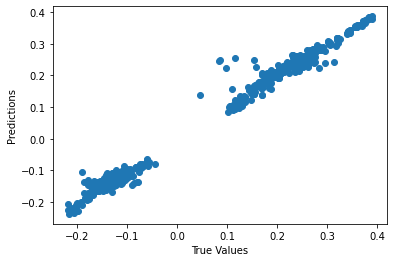

In [209]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")

In [210]:
idx = np.where(np.linalg.norm(predictions[:, :-1] - Y_test[:, :-1], axis=1) == np.max(np.linalg.norm(predictions[:, :-1] - Y_test[:, :-1], axis=1)))[0]

In [211]:
print(f'Command: {X_test[idx, 0:3]}. Start: {X_test[idx, 6:8]}. Groundtruth: {Y_test[idx]}. Predicted: {predictions[idx]}')

Command: [[0.725299 0.       0.      ]]. Start: [[ 0.188 -0.126]]. Groundtruth: [[ 0.085 -0.135]]. Predicted: [[ 0.24959873 -0.11420195]]


In [214]:
for idx, prediction in enumerate(predictions):
    print(f'Input: {X_test[idx, :3]}. State: {X_test[idx, 3:6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

Input: [0.1 0.  0. ]. State: [ 0.22274    -0.00152397 -0.0572529 ]. Groundtruth: [ 0.263281 -0.137156]. Predicted: [ 0.2604137  -0.13276918]
Input: [ 0.   0.  -0.1]. State: [ 0.180346  -0.0032861 -0.117973 ]. Groundtruth: [ 0.23982  -0.127754]. Predicted: [ 0.23427826 -0.1289044 ]
Input: [0.       0.611591 0.      ]. State: [0.130356  0.102058  0.0143828]. Groundtruth: [ 0.236804 -0.116842]. Predicted: [ 0.23678452 -0.11755646]
Input: [ 0.       -0.409412  0.      ]. State: [0.135183   0.0459911  0.00250181]. Groundtruth: [ 0.226673 -0.13458 ]. Predicted: [ 0.23258008 -0.11870538]
Input: [-0.809811  0.        0.      ]. State: [-0.0559223  0.073566  -0.0666583]. Groundtruth: [ 0.140885 -0.126684]. Predicted: [ 0.16274767 -0.12932715]
Input: [0.409412 0.       0.      ]. State: [ 0.275866  -0.0442641 -0.223334 ]. Groundtruth: [ 0.318822  -0.0790898]. Predicted: [ 0.31139131 -0.09673651]
Input: [ 0.        0.       -0.611591]. State: [ 0.161496   0.0185375 -0.861265 ]. Groundtruth: [ 0.2

In [24]:
plot_target_and_predictions("Predictions vs Target (x)", predictions[:, 0], Y_test[:, 0])

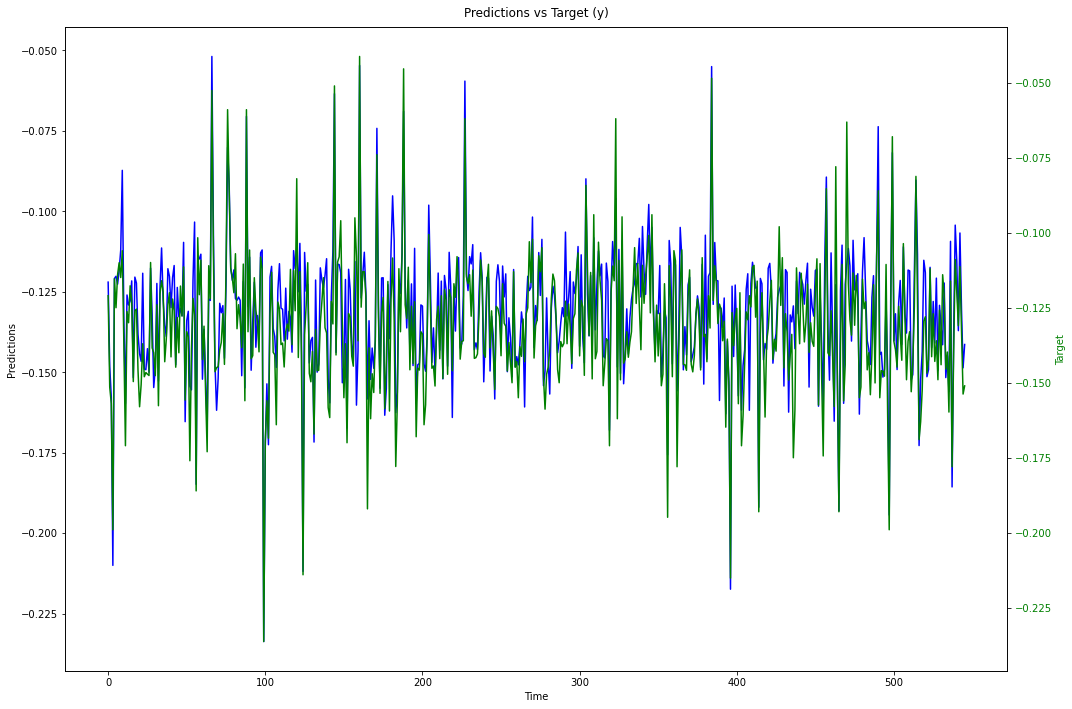

In [25]:
plot_target_and_predictions("Predictions vs Target (y)", predictions[:, 1], Y_test[:, 1])

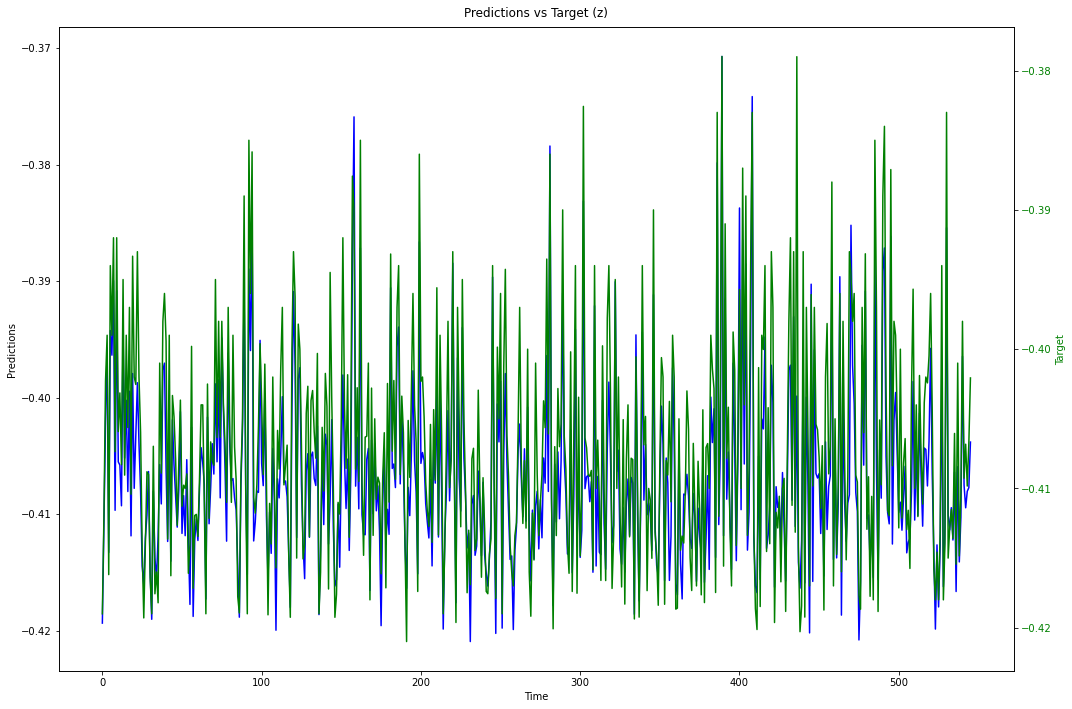

In [26]:
plot_target_and_predictions("Predictions vs Target (z)", predictions[:, 2], Y_test[:, 2])

## Predict FR foot -> x

### Simple Linear Regression

In [165]:
# Stack motion command, velocity state, 
# and foot x coordinate. The last row
# is not considered
X = np.hstack((X_motions_3D[:, :3], X_motions_3D[:, 3:6], np.array([X_motions_3D[:, 6]]).T, np.array([X_motions_3D[:, 9]]).T))
#X = np.hstack((X_motions_3D[:, :3], X_motions_3D[:, 3:6], X_motions_3D[:, 6:8], X_motions_3D[:, 9:11]))

# Label matrix which consists only of
# the next x coordinate of the FR foot.
# We dont consider the first row.
Y = np.array([Y_motions_3D[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, test_size=0.2, random_state=42, shuffle=True)

# Create the model
model_fr_x = LinearRegression()

# Fit the model
model_fr_x.fit(X_train, Y_train)

# Predict
predictions = model_fr_x.predict(X_test)

# Stats
print("Model score: ", model_fr_x.score(X_test, Y_test))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
print("The mean squared avg. error between the prediction and groundtruth is: ", mean_squared_error(Y_test, predictions))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

Model score:  0.8845825836122759
The lowest error is:  5.285666917709264e-06
The highest error is:  0.1655845120015177
The avg. error is:  0.009312404999842518
The mean squared avg. error between the prediction and groundtruth is:  0.0002471739299818911


Text(0, 0.5, 'Predictions')

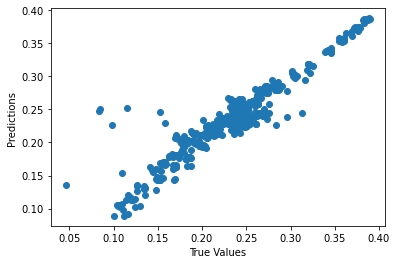

In [166]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")

In [215]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

### Polynomial Regression

In [218]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

In [230]:
# Stack motion command, velocity state, 
# and foot x coordinate. The last row
# is not considered
X = np.hstack((X_motions_3D[:, :3], X_motions_3D[:, 3:6], np.array([X_motions_3D[:, 6]]).T, np.array([X_motions_3D[:, 9]]).T))
#X = np.hstack((X_motions_3D[:, :3], X_motions_3D[:, 3:6], X_motions_3D[:, 6:8], X_motions_3D[:, 9:11]))

# Label matrix which consists only of
# the next x coordinate of the FR foot.
# We dont consider the first row.
Y = np.array([Y_motions_3D[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, test_size=0.2, random_state=42, shuffle=True)

# PolynomialFeatures (prepreprocessing)
poly = PolynomialFeatures(degree=3)
X_train_ = poly.fit_transform(X_train)
X_test_ = poly.fit_transform(X_test)

# Instantiate
model_fr_x = LinearRegression()

# Fit
model_fr_x.fit(X_train_, Y_train)

# Obtain coefficients
#model_fr_x.coef_

# Create the model
#model_fr_x = LinearRegression()

# Fit the model
#model_fr_x.fit(X_train, Y_train)

# Predict
predictions = model_fr_x.predict(X_test_)

# Stats
#print("Model score: ", model_fr_x.score(X_test_, Y_test_))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
print("The mean squared avg. error between the prediction and groundtruth is: ", mean_squared_error(Y_test, predictions))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

The lowest error is:  2.5963433939735214e-06
The highest error is:  0.1046981854228159
The avg. error is:  0.005189937671059667
The mean squared avg. error between the prediction and groundtruth is:  9.931420233641153e-05


Text(0, 0.5, 'Predictions')

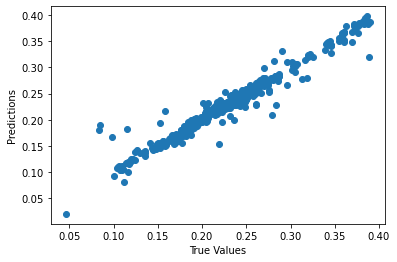

In [231]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")

### Predict FR foot -> y

In [198]:
# Stack motion command, velocity state, 
# and foot x coordinate. The last row
# is not considered
X = np.hstack((X_motions_3D[:, :3], X_motions_3D[:, 3:6], np.array([X_motions_3D[:, 7]]).T, np.array([X_motions_3D[:, 10]]).T))
#X = np.hstack((X_motions_3D[:, :3], X_motions_3D[:, 3:6], X_motions_3D[:, 6:8], X_motions_3D[:, 9:11]))

# Label matrix which consists only of
# the next x coordinate of the FR foot.
# We dont consider the first row.
Y = np.array([Y_motions_3D[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, test_size=0.2, shuffle=True)

# Create the model
model_fr_y = LinearRegression()

# Fit the model
model_fr_y.fit(X_train, Y_train)

# Predict
predictions = model_fr_y.predict(X_test)

# Stats
print("Model score: ", model_fr_y.score(X_test, Y_test))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
print("The mean squared avg. error between the prediction and groundtruth is: ", mean_squared_error(Y_test, predictions))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

Model score:  0.7692292791552721
The lowest error is:  7.3114199217461096e-06
The highest error is:  0.05915235670705295
The avg. error is:  0.007496440130786701
The mean squared avg. error between the prediction and groundtruth is:  0.00012356263961635534


Text(0, 0.5, 'Predictions')

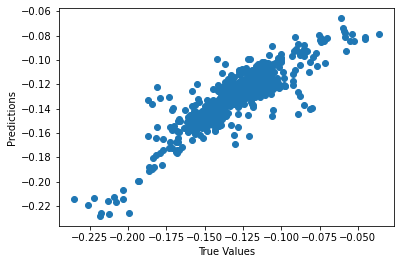

In [199]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")

In [206]:
Y_motions_3D[0]

array([ 0.199479, -0.143072, -0.412846,  0.253749,  0.153074, -0.399809,
       -0.225485, -0.109741, -0.416243, -0.273453,  0.142249, -0.411675])

In [207]:
X_test[0]

array([ 0.       ,  0.725299 ,  0.       ,  0.227376 , -0.0378932,
        0.11115  , -0.110261 ,  0.102364 ])

In [202]:
for idx, prediction in enumerate(predictions):
    print(f'Start: {X_test[idx, 7]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

Start: 0.102364. Groundtruth: [-0.151486]. Predicted: [-0.15608724]
Start: 0.147217. Groundtruth: [-0.122409]. Predicted: [-0.12203439]
Start: 0.150078. Groundtruth: [-0.115999]. Predicted: [-0.12428783]
Start: 0.105172. Groundtruth: [-0.160785]. Predicted: [-0.15474682]
Start: 0.127585. Groundtruth: [-0.144824]. Predicted: [-0.13570012]
Start: 0.1564. Groundtruth: [-0.106735]. Predicted: [-0.12159038]
Start: 0.128237. Groundtruth: [-0.122821]. Predicted: [-0.12638445]
Start: 0.101522. Groundtruth: [-0.152981]. Predicted: [-0.16209159]
Start: 0.154744. Groundtruth: [-0.105013]. Predicted: [-0.11670576]
Start: 0.20546. Groundtruth: [-0.0612976]. Predicted: [-0.06579974]
Start: 0.131103. Groundtruth: [-0.141549]. Predicted: [-0.13521676]
Start: 0.065. Groundtruth: [-0.165]. Predicted: [-0.17182343]
Start: 0.12033. Groundtruth: [-0.141073]. Predicted: [-0.13413182]
Start: 0.11439. Groundtruth: [-0.156349]. Predicted: [-0.15730831]
Start: 0.113239. Groundtruth: [-0.134617]. Predicted: [-0.

### Predict FR foot -> z

In [32]:
# Stack motion command, velocity state, 
# and foot x coordinate in order to 
# create the input matrix. We dont consider
# the last row.
X = np.hstack((X_motions_3D[:, :3], X_motions_3D[:, 3:6], np.array([X_motions_3D[:, 8]]).T, np.array([X_motions_3D[:, 11]]).T))
print("Input shape: ", X.shape)

# Label matrix which consists only of
# the next x coordinate of the FR foot.
# We dont consider the first row.
Y = np.array([Y_motions_3D[:, 2]]).T
print("Labels shape: ", Y.shape)

# Make sure we have the same
# number of rows for both labels
# and input
assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=42)

# Create the model
model_fr_z = LinearRegression()

# Fit the model
model_fr_z.fit(X_train, Y_train)

# Predict
predictions = model_fr_z.predict(X_test)
print("Predictions shape: ", predictions.shape)

# Compute MSE
mse = np.sum((predictions - Y_test)**2) / predictions.shape[0]

# MSE stats
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
print("The mean squared avg. error between the prediction and groundtruth is: ", mse)

Input shape:  (5459, 8)
Labels shape:  (5459, 1)
Predictions shape:  (546, 1)
The lowest error is:  1.3341082618190114e-05
The highest error is:  0.020698214389273106
The avg. error is:  0.003504285116902061
The mean squared avg. error between the prediction and groundtruth is:  2.0064704229719878e-05


In [84]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')